# Benchmarking spatial mapping of cell types in the mouse brain

## Loading packages

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
cell2location

<module 'cell2location' from '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/cell2location/__init__.py'>

## 1. Loading cell2location results <a name="loading"></a>

In [3]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'
sp_results_folder = f'{results_folder}'
sc_data_folder = f'/nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/'

#run_name = 'LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlpha_5experiments_121clusters_1393locations_13565genes_n_comb150_mean_var5_30k_y_s200_gl1'
run_name = 'LocationModelLinearDependentWMultiExperiment_121clusters_1393locations_13566genes_n_comb150_mean_var5_30k'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

adata_vis.obs[adata_vis.uns['mod']['fact_names']] = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata_snrna_raw = anndata.read(sc_data_folder + 'benchmark_SSp_PAR-POST-PRE.h5ad')
adata_snrna_raw.shape

(6948, 38377)

In [5]:
SSp = adata_snrna_raw[adata_snrna_raw.obs['region_label'] == 'SSp',:]
SSp_L1 = SSp[SSp.obs['layer_label'] == 'L1', :]
SSp_L2 = SSp[SSp.obs['layer_label'] == 'L2-3', :]
SSp_L4 = SSp[SSp.obs['layer_label'] == 'L4', :]
SSp_L1.obs['external_donor_name_id'].value_counts(), SSp_L2.obs['external_donor_name_id'].value_counts(),\
SSp_L4.obs['external_donor_name_id'].value_counts(), len(SSp.obs['external_donor_name_id'].unique())

(290    20
 291    11
 Name: external_donor_name_id, dtype: int64,
 267    142
 147    111
 322     80
 171     72
 303     72
 332     71
 341     71
 299     70
 331     69
 330     67
 290     65
 161     64
 323     64
 170     61
 150     56
 300     46
 Name: external_donor_name_id, dtype: int64,
 305    145
 310     92
 332     76
 289     72
 342     72
 330     71
 171     70
 299     69
 341     69
 331     66
 170     64
 304     64
 311     47
 167     39
 291     16
 Name: external_donor_name_id, dtype: int64,
 41)

## 2. Extract gold standard annotations <a name="loading2"></a>

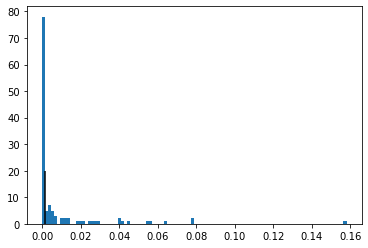

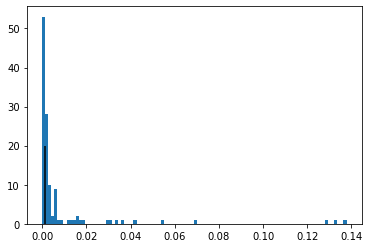

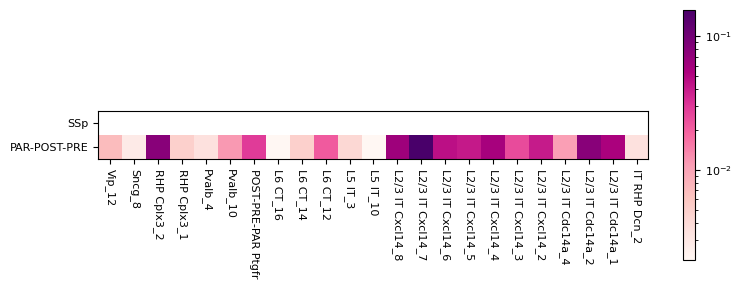

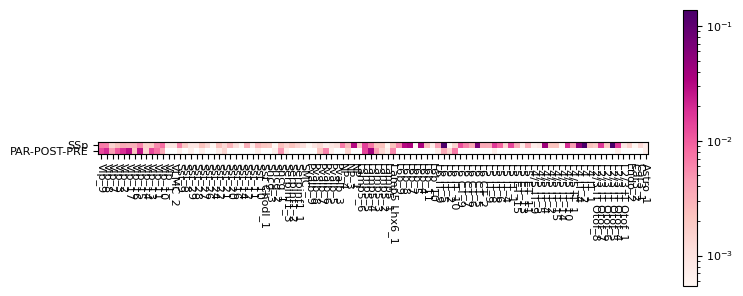

In [6]:
# the distribution of cell types across regions
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['region_label'].unique():
    ind = adata_snrna_raw.obs['region_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()
    

lay = lay / lay.sum(0)

# selecting cell types very specific to PAR-POST-PRE compared to SSp
plt.hist(lay['PAR-POST-PRE'], bins=100);
plt.vlines(0.0015, 0, 20, color='black');
plt.show();

lay_PAR_POST_PRE = lay.loc[(lay['SSp'] == 0) & (lay['PAR-POST-PRE'] > 0.0005), :]
lay_PAR_POST_PRE = lay_PAR_POST_PRE.loc[np.sort(list(lay_PAR_POST_PRE.index)), :]

# selecting cell types very specific to PAR-POST-PRE compared to SSp
plt.hist(lay['SSp'], bins=100);
plt.vlines(0.0015, 0, 20, color='black');
plt.show();

lay_SSp_stringent = lay.loc[(lay['SSp'] > 0.0015) & (lay['PAR-POST-PRE'] == 0), :]
lay_SSp = lay.loc[(lay['SSp'] > 0.0005), :]
lay_SSp = lay_SSp.loc[np.sort(list(lay_SSp.index)), :]

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 8, 'axes.facecolor': "white"}):
    from cell2location.plt.plot_heatmap import clustermap
    clustermap(lay_PAR_POST_PRE.T, figure_size=(8, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)
    clustermap(lay_SSp.T, figure_size=(8, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)

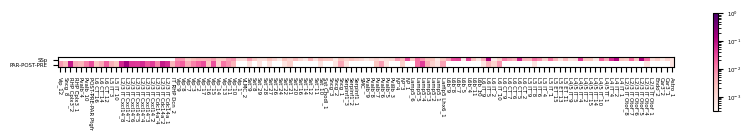

In [7]:
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['region_label'].unique():
    ind = adata_snrna_raw.obs['region_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()
lay_binary_all = lay > 0
    
# reorder according to broad class
clearly_separated = [i for i in lay_SSp.index] + [i for i in lay_PAR_POST_PRE.index]
lay = lay.loc[clearly_separated, :]

#lay = lay.loc[lay.sum(1) > 15, :]
lay = lay / lay.sum(0)

lay_binary = lay > 0

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(lay.T, figure_size=(8.3, 1.3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               vmin=0.0003, vmax=1)
    plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_reference.pdf', bbox_inches='tight')
    plt.show()

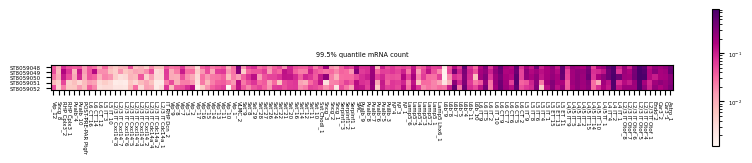

In [8]:
def quantile_by(adata, sel_clust = lay_binary.index.values,
                post_type = 'q05_spot_factors',
                by_col = 'sample', quantile=0.995, proportion=True):
    sel_clust_col = [f'{post_type}{i}' for i in sel_clust]
    infer_lay_df = adata.obs[sel_clust_col]
    infer_lay_df.columns = sel_clust
    if proportion:
        infer_lay_df = (infer_lay_df.T / infer_lay_df.sum(1)).T
    infer_lay_df[infer_lay_df.isna()] = 0

    infer_lay = pd.DataFrame(index=sel_clust)
    for r in adata.obs[by_col].unique():
        ind = adata.obs[by_col].isin([r])
        # sum / mean of cell density across all spots within a region
        infer_lay[r] = np.quantile(infer_lay_df.loc[ind, :], quantile, axis=0)
    
    return infer_lay
    

infer_lay_nUMI = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'q05_spot_factors',
                by_col = 'sample')
gold_standard_lay = np.array([lay_binary['SSp'] for i in range(infer_lay_nUMI.shape[1])]).T

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(infer_lay_nUMI.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=30, vmax=10000
              )
    plt.title('99.5% quantile mRNA count');
    plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

In [9]:
# call columns with q05_nUMI_factors as cell2location
sel_clust_col = [f'q05_spot_factors{i}' for i in lay_binary.index.values]
adata_vis.obs[[f'cell2location_{i}' for i in lay_binary.index.values]] = adata_vis.obs[sel_clust_col]

## Compare methods using PR-curves

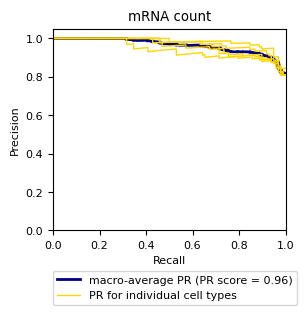

In [10]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']


def compute_precision_recall(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = average_precision_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = precision_recall_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def compute_roc(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot ROC curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = roc_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = roc_auc_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = roc_auc_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = roc_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def plot_precision_recall(pos_cell_count, infer_cell_proportions,
                          title='', iso_f1_curves=False,
                          individual_cell_types=True,
                          save=None, mode='macro', curve='PR'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    :param title: plot title
    :param iso_f1_curves: plot iso curves for F1 score?
    :param individual_cell_types: show precision-recall curves for each cell type?
    """
    
    ### calculating ###
    if curve == 'PR':
        precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'Recall'
        ylabel = 'Precision'
        
    elif curve == 'ROC':
        recall, precision, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'FPR'
        ylabel = 'TPR'
        
    ### plotting ###
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    lines = []
    labels = []
    
    if iso_f1_curves:
        f_scores = np.linspace(0.2, 0.8, num=4)
        
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
    
    l, = plt.plot(recall["averaged"], precision["averaged"], color='navy', lw=2)
    lines.append(l)
    labels.append(f'{mode}-average {curve} ({curve} score = {round(average_precision["averaged"], 2)})')

    if individual_cell_types:
        for i, color in zip(infer_cell_proportions.columns, colors):
            l, = plt.plot(recall[i], precision[i], color='gold', lw=1)
            lines.append(l)
        labels.append(f'{curve} for individual cell types')



    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -.37), prop=dict(size=8))
    
    if save is not None:
        plt.savefig(save)

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.37),
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=3)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=3)
            
        
        lines.append(l)

        labels.append(method_title[i] + '(' + curve + ' score = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=14))

    #plt.show()
    return roc

with mpl.rc_context({"figure.figsize": (3, 3.2),
                            'pdf.fonttype': 42, "font.size": 8}):
    plot_precision_recall(gold_standard_lay, infer_lay_nUMI,
                          title='mRNA count', mode='macro',
                         save=f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping_prec_recall.pdf'
                         )
    plt.show()

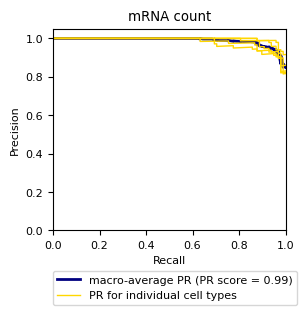

In [11]:
infer_lay_mRNA = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'q05_nUMI_factors',
                by_col = 'sample', proportion=False)

with mpl.rc_context({"figure.figsize": (3, 3.2),
                            'pdf.fonttype': 42, "font.size": 8}):
    plot_precision_recall(gold_standard_lay, infer_lay_mRNA,
                          title='mRNA count', mode='macro',
                         save=f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping_prec_recall_mRNA.pdf'
                         )
    plt.show()

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


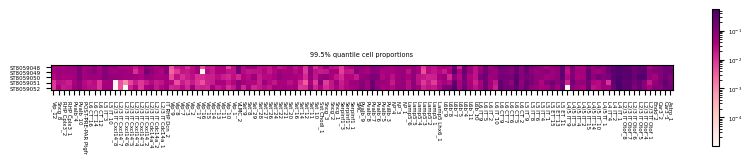

In [12]:
results_folder_st = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/allen_negative/'
RCTD = pd.read_csv(f'{results_folder_st}rctd/results_weights_121clusters_3246genes_6367genes.csv',
                   index_col='spot')
adata_vis = adata_vis[adata_vis.obs_names.isin(RCTD.index),:]

# compute cell proportions
RCTD = (RCTD.T / RCTD.sum(1)).T
RCTD = RCTD.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'RCTD_{i}' for i in RCTD.columns]] = RCTD.values

RCTD = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'RCTD_',
                by_col = 'sample')

results = [RCTD]
names = ['RCTD']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(RCTD.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('99.5% quantile cell proportions');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

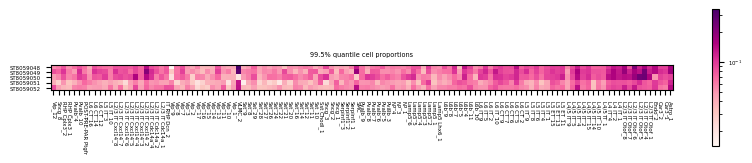

In [13]:
scvi_stereoscope = anndata.read(f'{results_folder_st}scvi_stereoscope/sp_20k.h5ad')

scvi_stereoscope = scvi_stereoscope.obsm['deconvolution'].copy()
scvi_stereoscope = (scvi_stereoscope.T / scvi_stereoscope.sum(1)).T
scvi_stereoscope = scvi_stereoscope.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'scVI_Stereoscope_{i}' for i in scvi_stereoscope.columns]] = scvi_stereoscope.values

scvi_stereoscope = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'scVI_Stereoscope_',
                by_col = 'sample')

results = results + [scvi_stereoscope]
names = names + ['scVI_Stereoscope']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(scvi_stereoscope.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('99.5% quantile cell proportions');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

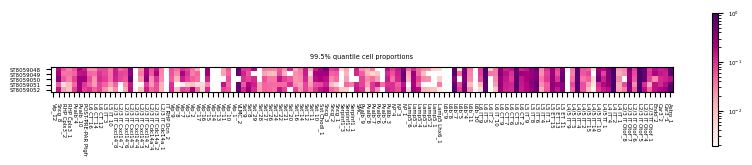

In [14]:
SeuratV3 = pd.read_csv(f'{results_folder_st}seurat_new/results_pca.csv',
                       index_col='spot')
SeuratV3 = SeuratV3.drop(columns=['prediction.score.max', 'Unnamed: 0', 'predicted.id'])
from re import sub
SeuratV3.columns = [sub('prediction.score.', '',i) for i in SeuratV3.columns]

seu_index = [sub(' ', '.',i) for i in infer_lay_nUMI.index]
seu_index = [sub('/', '.',i) for i in seu_index]
seu_index = [sub('-', '.',i) for i in seu_index]

SeuratV3 = SeuratV3[seu_index]
SeuratV3.columns = infer_lay_nUMI.index

# compute cell proportions
SeuratV3 = (SeuratV3.T / SeuratV3.sum(1)).T
SeuratV3 = SeuratV3.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'Seurat_{i}' for i in SeuratV3.columns]] = SeuratV3.values

SeuratV3 = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'Seurat_',
                by_col = 'sample')

results = results + [SeuratV3]
names = names + ['Seurat']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(SeuratV3.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('99.5% quantile cell proportions');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

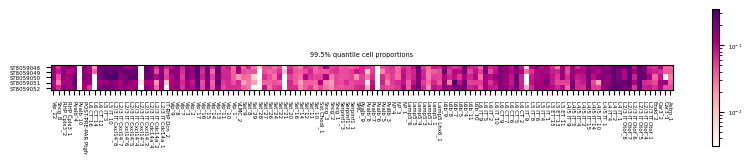

In [15]:
SPOTlight = pd.read_csv(f'{results_folder_st}SPOTlight/results_hvg5k.csv',
                       index_col='rn')
SPOTlight = SPOTlight.drop(columns=['res_ss'])
from re import sub

seu_index = [sub(' ', '.',i) for i in infer_lay_nUMI.index]
seu_index = [sub('/', '.',i) for i in seu_index]
seu_index = [sub('-', '.',i) for i in seu_index]
seu_index = [sub('_', '.',i) for i in seu_index]

SPOTlight = SPOTlight[seu_index]
SPOTlight.columns = infer_lay_nUMI.index

# compute cell proportions
SPOTlight = (SPOTlight.T / SPOTlight.sum(1)).T
SPOTlight[SPOTlight.isna()] = 0

SPOTlight = SPOTlight.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'SPOTlight_{i}' for i in SPOTlight.columns]] = SPOTlight.values

SPOTlight = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'SPOTlight_',
                by_col = 'sample')

results = results + [SPOTlight]
names = names + ['SPOTlight']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(SPOTlight.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('99.5% quantile cell proportions');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

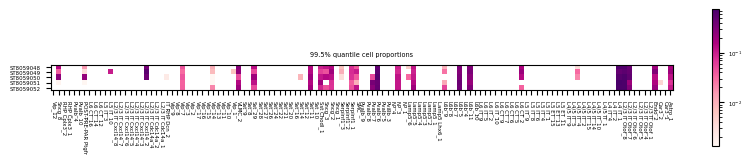

In [16]:
nnls = pd.read_csv(f'{results_folder_st}autogenes_models/coef_nnls_seed.csv', index_col=0).T

# compute cell proportions
nnls = (nnls.T / nnls.sum(1)).T
nnls[nnls.isna()] = 0

nnls = nnls.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'NNSL_{i}' for i in nnls.columns]] = nnls.values

nnls = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'NNSL_',
                by_col = 'sample')

results = results + [nnls]
names = names + ['NNSL']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(nnls.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('99.5% quantile cell proportions');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

In [17]:
results =  [infer_lay_nUMI] + results
names = ['cell2location'] + names

In [18]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/LocationModelLinearDependentWMultiExperiment_121clusters_1393locations_13566genes_n_comb150_mean_var5_30k/plots/figures/'

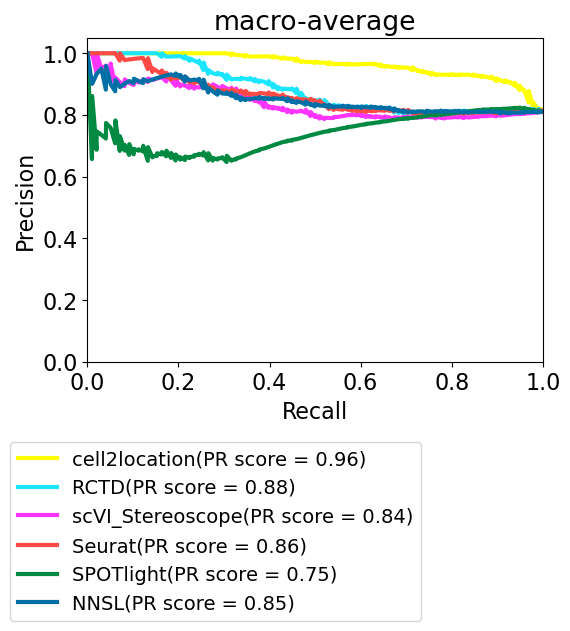

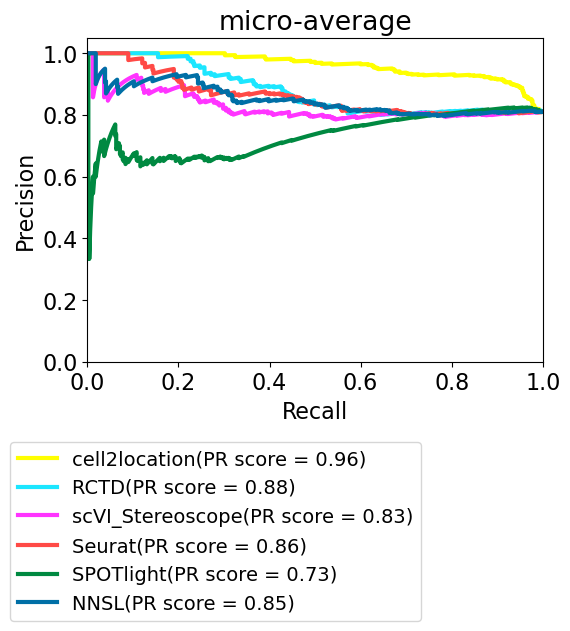

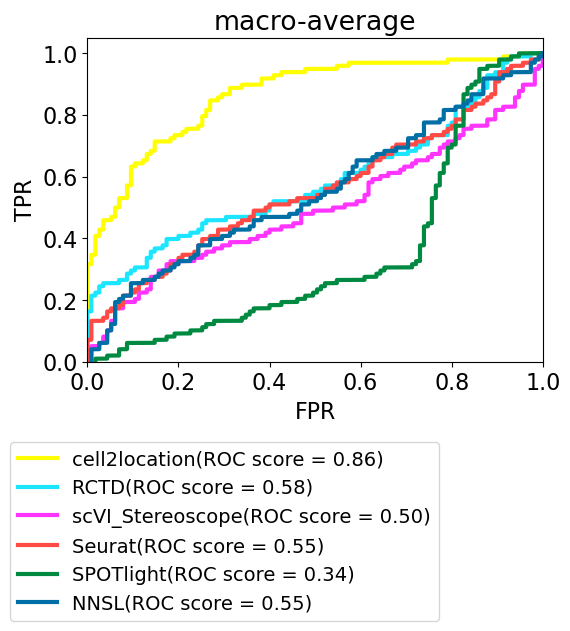

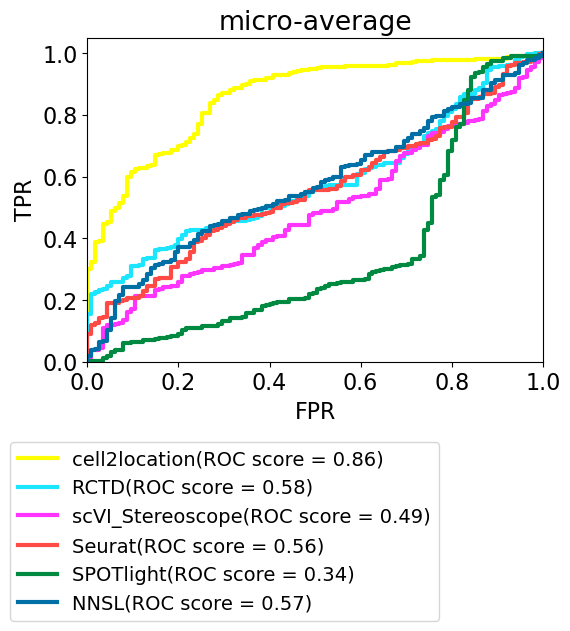

In [19]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (6,7.5), 'font.size': 16}):
    
    for c in ['PR', 'ROC']:
        for m in ['macro', 'micro']:
            compare_precision_recall(gold_standard_lay, results,
                                     method_title=names, 
                                     legend_loc=(-0.17, -0.8),
                                     mode=m, curve=c)#,
                                     #colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
            plt.tight_layout()
            plt.title(f'{m}-average')
            plt.savefig(f'{fig_path}/{c}_comparison_all_{m}average.pdf')
            plt.show()

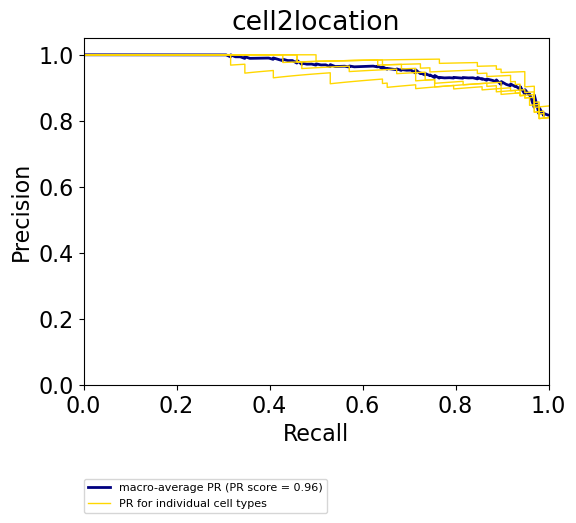

In [20]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (6,5.5), 'font.size': 16}):
    plot_precision_recall(gold_standard_lay, results[0], title=names[0])

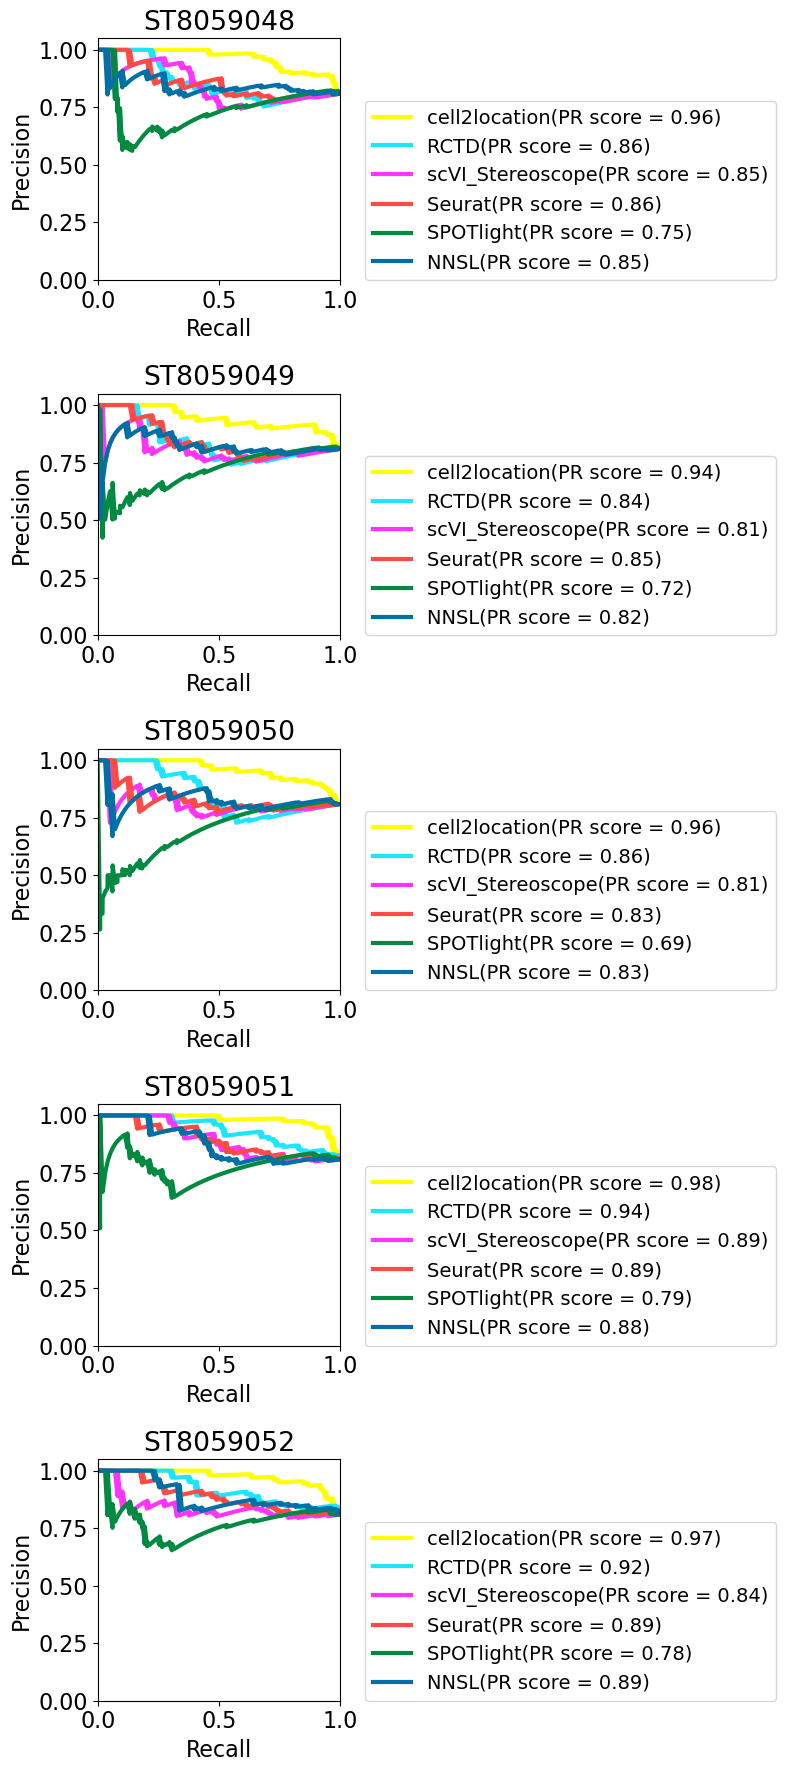

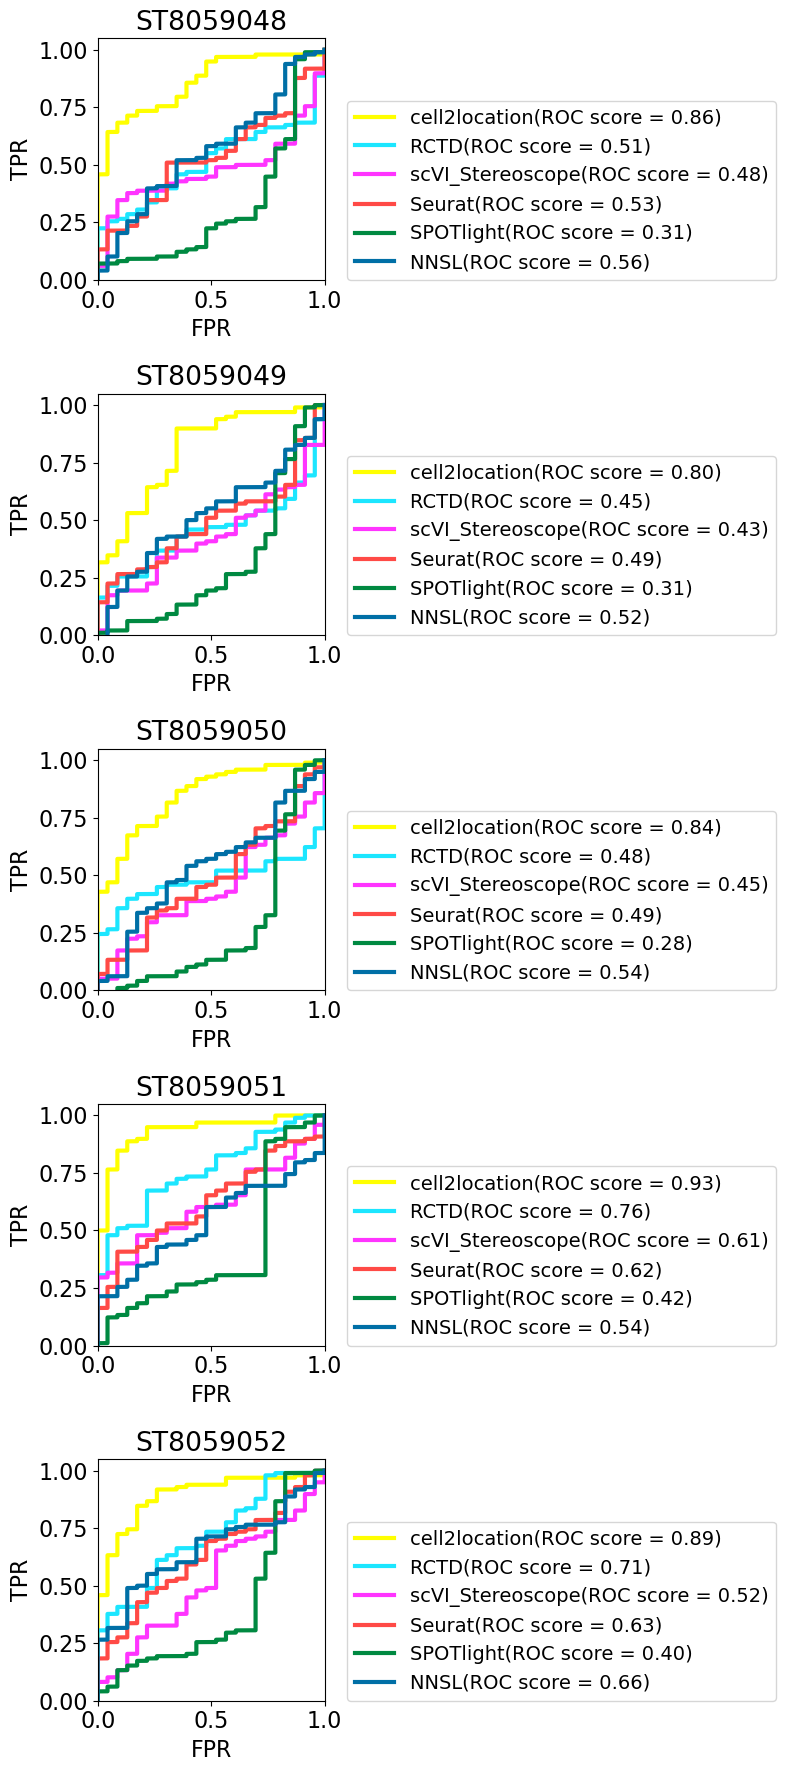

In [21]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (8,18), 'font.size': 16}):
    
    col_ind = results[0].columns

    for c in ['PR', 'ROC']:
        for i, ct in enumerate(col_ind):

            plt.subplot(len(col_ind), 1, i+1)
            compare_precision_recall(gold_standard_lay[:, np.isin(col_ind, ct)].reshape((gold_standard_lay.shape[0], 1)), 
                                     [i[[ct]] for i in results],
                                     method_title=names, 
                                     legend_loc=(1.1, 0),
                                     curve=c
                                     #colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']
                                    )
            plt.tight_layout()
            plt.title(f'{ct}')
        plt.savefig(f'{fig_path}/{c}_comparison_all_cell_types.pdf')
        plt.show()

## Plot consistency with Allen cell proportions (Fig 2J)

First, extract the proportion of each cell type in layers from Allen scRNA-seq data

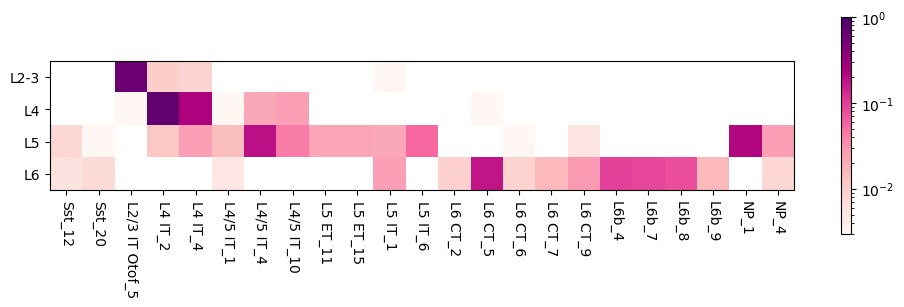

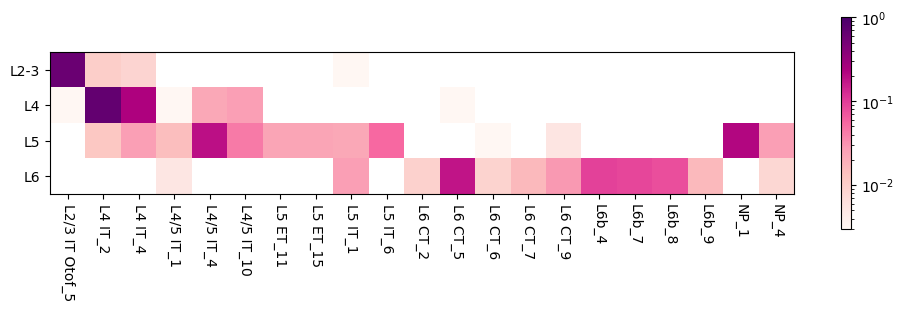

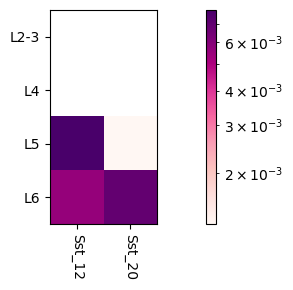

(23, 4)

In [22]:
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['layer_label'].unique():
    ind = adata_snrna_raw.obs['layer_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()

lay = lay[['L2-3', 'L4', 'L5', 'L6']]
lay[lay.isna()] = 0

lay_count = lay.copy()
lay_count = lay_count / lay_count.sum(0)

lay = lay.loc[lay_SSp_stringent.index]
lay = lay.loc[lay.sum(1) > 15, :]
lay = lay_count.loc[lay.index,:]
    
# reorder according to broad class
broad_class = adata_snrna_raw.obs[['class_label', 'cluster_label']].drop_duplicates()
broad_class.index = broad_class['cluster_label']
broad_class = broad_class.drop(columns='cluster_label')
broad_class = broad_class.sort_values(['class_label', 'cluster_label'], ascending=False)
index = list(broad_class.index[broad_class.index.isin(lay.index)])
lay = lay.loc[index, :]

with mpl.rc_context({"font.size": 10, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    clustermap(lay.T, figure_size=(10, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               vmin=0.003, vmax=1)
    plt.savefig(f'{fig_path}Fig2J_suppl_reference.pdf', bbox_inches='tight')
    plt.show()

with mpl.rc_context({"font.size": 10, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    index_subset = list(broad_class[broad_class['class_label'].isin(['Glutamatergic'])].index)
    index_subset = np.array(index_subset)[np.isin(index_subset, lay.index)]
    lay_subset = lay.loc[index_subset,:].T
    clustermap(lay_subset, 
               figure_size=(10, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               vmin=0.003, vmax=1)
    plt.savefig(f'{fig_path}Fig2J_reference.pdf', bbox_inches='tight')
    plt.show()

with mpl.rc_context({"font.size": 10, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    GABAergicindex_subset = list(broad_class[broad_class['class_label'].isin(['GABAergic'])].index)
    GABAergicindex_subset = np.array(GABAergicindex_subset)[np.isin(GABAergicindex_subset, lay.index)]
    lay_subset = lay.loc[GABAergicindex_subset,:].T
    clustermap(lay_subset, 
               figure_size=(10, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.savefig(f'{fig_path}Fig2J_reference_GABAergic.pdf', bbox_inches='tight')
    plt.show()

lay.shape

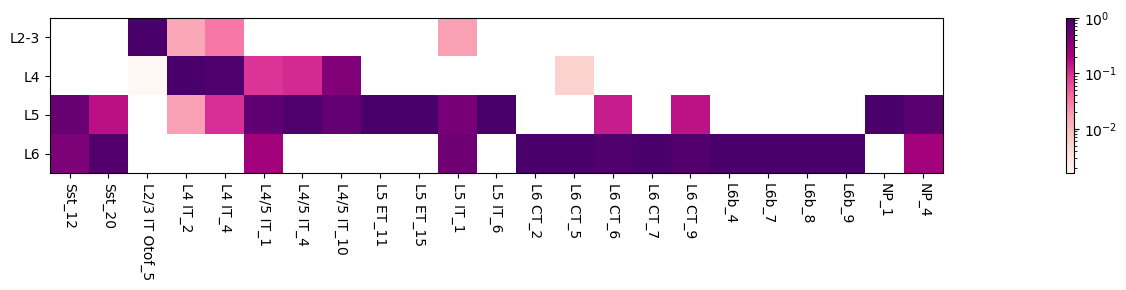

In [23]:
with mpl.rc_context({"font.size": 10, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    clustermap(lay.T / lay.sum(1), figure_size=(25, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.003, vmax=1
              )
    plt.savefig(f'{fig_path}Fig2J_suppl_reference_max.pdf', bbox_inches='tight')
    plt.show()

In [24]:
# Define functions that compute per layer average abundance of each cell type & plot annotated scatterplot
def layer_distribution(slide, lay=None, layer_col='SSp_manual_layers', 
                       post_type='cell2location_', 
                       summary_fun=np.mean, proportion_per_layer=False):
    
    sel_clust_col = [post_type in i for i in slide.obs.columns]
    sel_clust_col = slide.obs.columns[sel_clust_col]
    from re import sub # create nice names
    sel_clust = [sub(post_type, '', i) for i in sel_clust_col]

    # log-transform and save with nice names
    #slides[s].obs[sel_clust] = np.log10(slides[s].obs[sel_clust_col])
    infer_lay_df = slide.obs[sel_clust_col]
    infer_lay_df.columns = sel_clust
    infer_lay_df = (infer_lay_df.T / infer_lay_df.sum(1)).T

    infer_lay = pd.DataFrame(index=sel_clust)
    for r in slide.obs[layer_col].unique():
        ind = slide.obs[layer_col].isin([r])
        # sum / mean of cell density across all spots within a region
        infer_lay[r] = summary_fun(infer_lay_df.loc[ind, :], axis=0)
    
    infer_lay = infer_lay[['L23', 'L4', 'L5', 'L6']]
    infer_lay.columns = ['L2-3', 'L4', 'L5', 'L6']
    #infer_lay = infer_lay.loc[infer_lay.sum(1) > 0, :]
    if lay is not None:
        infer_lay = infer_lay.loc[lay.index, :]
    infer_lay = infer_lay.loc[np.sort(list(infer_lay.index)), :]
    
    # convert to proportions per layer
    if proportion_per_layer is True:
        infer_lay = infer_lay / infer_lay.sum(0)
    infer_lay[infer_lay.isna()] = 0
    
    return infer_lay

def plot_hist2d(x, y, xlab, ylab, log=False, scatter_kwdargs:dict={}):
    
    corr = np.corrcoef(
        x.values.flatten(), 
        y.values.flatten())[0,1]
    corr_log10 = np.corrcoef(
        np.log10(x.values.flatten() + 1), 
        np.log10(y.values.flatten() + 1))[0,1]

    if log:
        x = np.log10(x.values.flatten() + 1)
        y = np.log10(y.values.flatten() + 1)
        
        xlab = xlab + ' (log10)'
        ylab = ylab + ' (log10)'
    else:
        x = x.values.flatten()
        y = y.values.flatten()

    #plt.hist2d(x, y, bins=35, norm=matplotlib.colors.LogNorm());
    plt.scatter(x, y, **scatter_kwdargs);
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    plt.xlim(0);
    plt.ylim(0);
    plt.title(r'$R^2$: ' \
              + str(np.round(corr, 3))\
              #+ r', $R^2$ log: '+ str(np.round(corr_log10, 3))
             );
    
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

def compute_corr(sample, method, lay, adata_vis):
    
    infer_lay_s = layer_distribution(select_slide(adata_vis, sample).copy(), 
                                     summary_fun=np.mean, proportion_per_layer=False,
                                     post_type=method)
    
    infer_lay_s = infer_lay_s / infer_lay_s.sum(0)
    infer_lay_s = infer_lay_s.loc[lay.index,:]
    
    corr = np.corrcoef(
        lay.values.flatten(), 
        infer_lay_s.values.flatten())[0,1]
    
    return corr
    

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


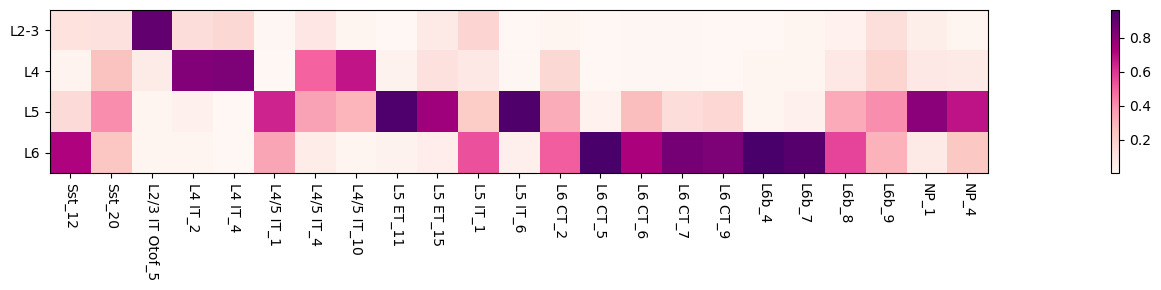

In [25]:
infer_lay_ST8059048 = layer_distribution(select_slide(adata_vis, 'ST8059048').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False,
                                         post_type='cell2location_')

infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)
infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index,:]

infer_lay_ST8059048 = infer_lay_ST8059048.T / infer_lay_ST8059048.sum(1)

with mpl.rc_context({"font.size": 10, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    clustermap(infer_lay_ST8059048, figure_size=(25, 3), 
               cmap='RdPu', #log=True,
               cluster_rows=False, cluster_cols=False)

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


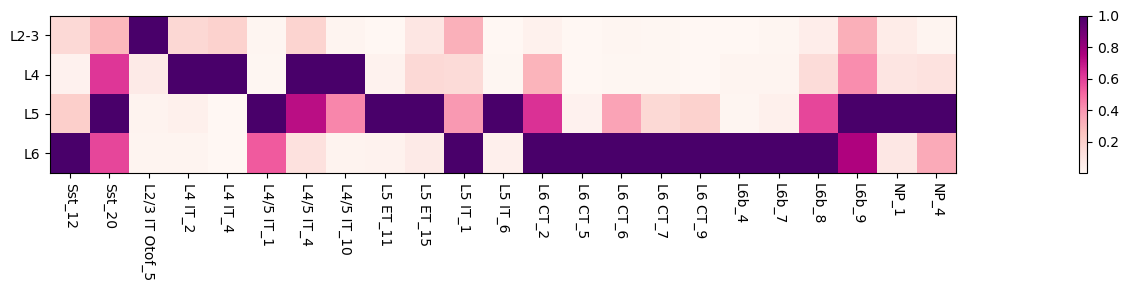

In [26]:
infer_lay_ST8059048 = layer_distribution(select_slide(adata_vis, 'ST8059048').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False,
                                         post_type='cell2location_')

infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)
infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index,:]

infer_lay_ST8059048 = infer_lay_ST8059048.T / infer_lay_ST8059048.max(1)

with mpl.rc_context({"font.size": 10, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    clustermap(infer_lay_ST8059048, figure_size=(25, 3), 
               cmap='RdPu', #log=True,
               cluster_rows=False, cluster_cols=False)
    plt.savefig(f'{fig_path}Fig2J_suppl_cell2location_max.pdf', bbox_inches='tight')

In [27]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/LocationModelLinearDependentWMultiExperiment_121clusters_1393locations_13566genes_n_comb150_mean_var5_30k/plots/figures/'

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


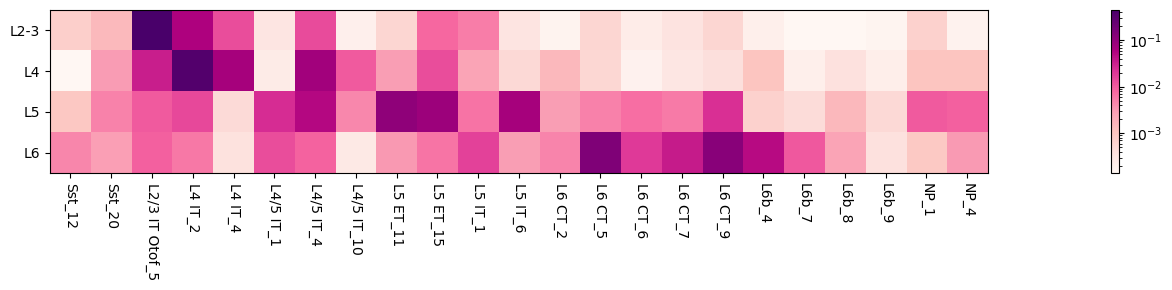

In [28]:
infer_lay_ST8059048 = layer_distribution(select_slide(adata_vis, 'ST8059048').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False,
                                         post_type='cell2location_')

infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)
infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index,:]

with mpl.rc_context({"font.size": 10, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    clustermap(infer_lay_ST8059048.T, figure_size=(25, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


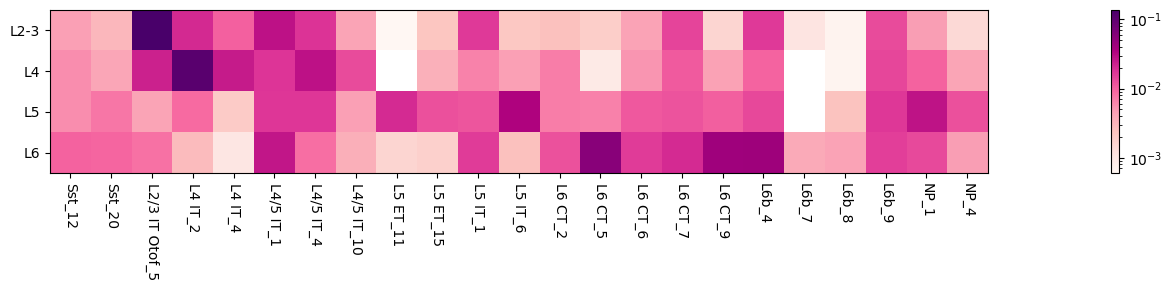

In [29]:
SPOTlight_infer_lay_ST8059048 = layer_distribution(select_slide(adata_vis, 'ST8059048').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False,
                                         post_type='SPOTlight_')

SPOTlight_infer_lay_ST8059048 = SPOTlight_infer_lay_ST8059048 / SPOTlight_infer_lay_ST8059048.sum(0)
SPOTlight_infer_lay_ST8059048 = SPOTlight_infer_lay_ST8059048.loc[lay.index,:]

with mpl.rc_context({"font.size": 10, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    clustermap(SPOTlight_infer_lay_ST8059048.T, figure_size=(25, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


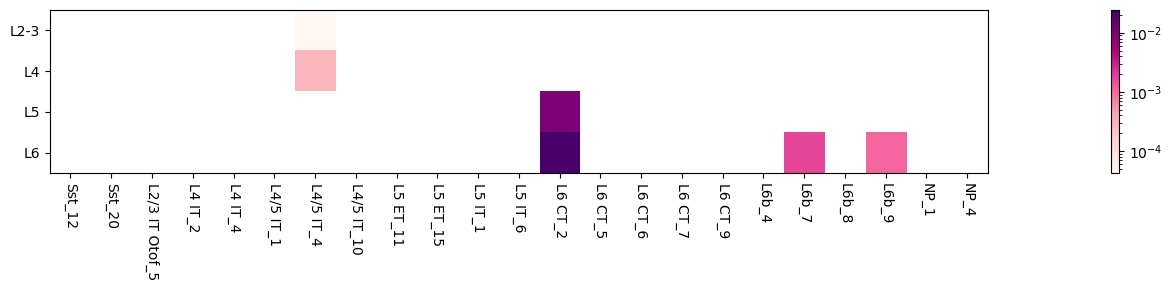

In [30]:
NNLS_infer_lay_ST8059048 = layer_distribution(select_slide(adata_vis, 'ST8059048').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False,
                                         post_type='NNSL_')

NNLS_infer_lay_ST8059048 = NNLS_infer_lay_ST8059048 / NNLS_infer_lay_ST8059048.sum(0)
NNLS_infer_lay_ST8059048 = NNLS_infer_lay_ST8059048.loc[lay.index,:]

with mpl.rc_context({"font.size": 10, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    clustermap(NNLS_infer_lay_ST8059048.T, figure_size=(25, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)

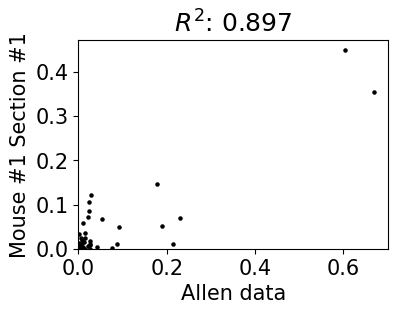

In [31]:
with mpl.rc_context({'axes.facecolor': 'white', 'font.size': 15,
                            'figure.figsize': [4, 4]}):
    
    #infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)
    infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index, :]
    
    plot_hist2d(lay, infer_lay_ST8059048, 
                'Allen data', 
                'Mouse #1 Section #1', 
               scatter_kwdargs={'s': 5, 'c': 'black'})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig(f'{fig_path}/Allen_reference_vs_cell2location_ST8059048.pdf', bbox_inches='tight')
    plt.show()

In [32]:
compute_corr(sample='ST8059048', method='cell2location_', 
             lay=lay, adata_vis=adata_vis)

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


0.8974310955395147

In [33]:
compute_corr(sample='ST8059052', method='RCTD_', 
             lay=lay, adata_vis=adata_vis)

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


0.74394893897497

In [34]:
names

['cell2location', 'RCTD', 'scVI_Stereoscope', 'Seurat', 'SPOTlight', 'NNSL']

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


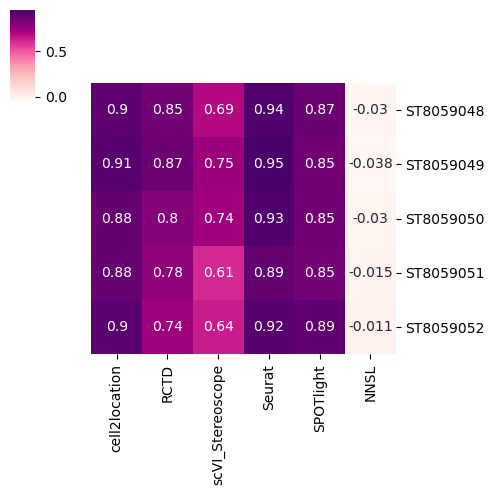

In [35]:
corrs = pd.DataFrame(index=['ST8059048', 'ST8059049', 'ST8059050', 'ST8059051', 'ST8059052'],#adata_vis.obs['sample'].unique(), 
                     columns=names)

for s in corrs.index:
    for m in corrs.columns:
        corrs.loc[s,m] = compute_corr(sample=s, method=m+'_', 
                                      lay=lay, adata_vis=adata_vis)

corrs = corrs.astype('float32')

with mpl.rc_context({'axes.facecolor': 'white', 'font.size': 10}):
    import seaborn as sns
    sns.clustermap(corrs, figsize=[5, 5], cmap='RdPu', 
                   row_cluster=False, col_cluster=False, 
                   annot=corrs)
    plt.savefig(f'{fig_path}/FigS9_Allen_reference_vs_all_method_all_samples.pdf', bbox_inches='tight')

with mpl.rc_context({'axes.facecolor': 'white', 'font.size': 10}):
    import seaborn as sns
    sns.boxplot(corrs, orient="h", palette=sc.pl.palettes.default_102).set(
        xlabel='Root mean squared error'
    )
    plt.tight_layout()

In [36]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y
    

## Plot locations of all cell types and all methods

In [37]:
# generate cell proportions for cell2location
sel_clust_col = [f'q05_spot_factors{i}' for i in lay_binary.index.values]
cell2location_proportion = adata_vis.obs[sel_clust_col].copy()
cell2location_proportion = (cell2location_proportion.T / cell2location_proportion.sum(1)).T
cell2location_proportion[cell2location_proportion.isna()] = 0
adata_vis.obs[[f'cell2location_proportion_{i}' for i in lay_binary.index.values]] = cell2location_proportion

In [38]:
names = ['cell2location_proportion'] + names
names

['cell2location_proportion',
 'cell2location',
 'RCTD',
 'scVI_Stereoscope',
 'Seurat',
 'SPOTlight',
 'NNSL']

In [39]:
list(lay_binary.index.copy())

['Astro_1',
 'Car3_1',
 'Car3_2',
 'Endo_2',
 'L2/3 IT Otof_1',
 'L2/3 IT Otof_4',
 'L2/3 IT Otof_5',
 'L2/3 IT Otof_6',
 'L2/3 IT Otof_7',
 'L2/3 IT Otof_8',
 'L4 IT_1',
 'L4 IT_2',
 'L4 IT_4',
 'L4/5 IT_1',
 'L4/5 IT_10',
 'L4/5 IT_14',
 'L4/5 IT_15',
 'L4/5 IT_2',
 'L4/5 IT_4',
 'L4/5 IT_5',
 'L4/5 IT_9',
 'L5 ET_11',
 'L5 ET_13',
 'L5 ET_15',
 'L5 IT_1',
 'L5 IT_4',
 'L5 IT_6',
 'L5 IT_8',
 'L5 IT_9',
 'L6 CT_2',
 'L6 CT_5',
 'L6 CT_6',
 'L6 CT_7',
 'L6 CT_9',
 'L6 IT_10',
 'L6 IT_2',
 'L6 IT_5',
 'L6 IT_9',
 'L6b_10',
 'L6b_11',
 'L6b_4',
 'L6b_5',
 'L6b_7',
 'L6b_8',
 'L6b_9',
 'Lamp5 Lhx6_1',
 'Lamp5_1',
 'Lamp5_2',
 'Lamp5_3',
 'Lamp5_4',
 'Lamp5_5',
 'Lamp5_6',
 'NP_1',
 'NP_3',
 'NP_4',
 'Pvalb_3',
 'Pvalb_5',
 'Pvalb_6',
 'Pvalb_7',
 'Pvalb_8',
 'Pvalb_9',
 'SMC',
 'Serpinf1_1',
 'Serpinf1_2',
 'Serpinf1_3',
 'Sncg_1',
 'Sncg_2',
 'Sncg_3',
 'Sst Chodl_1',
 'Sst_10',
 'Sst_11',
 'Sst_12',
 'Sst_14',
 'Sst_16',
 'Sst_20',
 'Sst_21',
 'Sst_22',
 'Sst_24',
 'Sst_26',
 'Sst_27',

In [40]:
ct_list=list(lay_binary.index.copy())

with mpl.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [9, 10]}):
    
    for m in names:
        for s in adata_vis.obs['sample'].unique():
        
            slide = select_slide(adata_vis, s)
            crop_x, crop_y = get_crop_coord(slide)

            if s == 'ST8059050':
                crop_x = [crop_x[0] + 50] + [crop_x[1] - 50]

            sc.pl.spatial(slide, cmap='magma',
                          color=[f'{m}_{i}' for i in ct_list], ncols=5, show=False,
                          #library_id=s,
                          size=1.3, img_key='hires', alpha_img=0, alpha=1,
                          frameon=True, legend_fontsize=50,
                          vmin=0, vmax='p99.2', save=f'all_maps_dot{s}_method{m}.pdf'
                     )

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Plot locations HPC cell types in one plot with the same scale

In [ ]:
def plot_spatial_per_cell_type_per_method(adata, 
                               cell_type=adata_vis.uns['mod']['fact_names'][0],
                               samples=[
       'WSA_LngSP8759310', 'WSA_LngSP8759311', 'WSA_LngSP9258462',
                                    
       'WSA_LngSP8759313', 'WSA_LngSP9258463', 'WSA_LngSP9258466',
                                   
       'WSA_LngSP9258467', 'WSA_LngSP8759312', 'WSA_LngSP9258465',
       'WSA_LngSP9258464', 'WSA_LngSP9258468', 'WSA_LngSP9258469',],
                              ncol=4):
    n_samples = len(samples)
    nrow = int(np.ceil(n_samples / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(24, 18))
    
    col_name = f'q05_spot_factors{cell_type}'
    vmax = np.quantile(adata_vis.obs[col_name].values, 0.992)
    adata_vis.obs[cell_type] = adata_vis.obs[col_name].copy()
    
    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
    
    for i, s in enumerate(samples):
        sp_data_s = select_slide(adata, s, s_col='sample')
        sc.pl.spatial(sp_data_s, cmap='magma',
                      color=cell_type, 
                      size=1.3, img_key='hires', alpha_img=1,
                      vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False
                                            )
        axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
        
    fig.tight_layout(pad=0.5)
        
    return fig


In [ ]:
plot_spatial_per_cell_type(adata_vis, cell_type=adata_vis.uns['mod']['fact_names'][0]);

In [ ]:
from re import sub
for c in adata_vis.uns['mod']['fact_names']:
    fig = plot_spatial_per_cell_type(adata_vis, cell_type=c)
    fig.savefig(f"{results_folder}{r['run_name']}/plots/spatial/per_cell_type/W_cell_abundance_q05_{sub('/', '_', c)}.png",
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)

f"{results_folder}{r['run_name']}/plots/spatial/per_cell_type/"


Modules and their versions used for this analysis

In [41]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass


sys 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
ipykernel 5.5.3
ipykernel._version 5.5.3
json 2.0.9
re 2.2.1
IPython 7.22.0
IPython.core.release 7.22.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.22.0
pygments 2.8.1
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.0.6
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.18
wcwidth 0.2.5
jedi 0.18.0
parso 0.8.2
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
IPython.core.magics.code 7.22.0
urllib.request 3.7
jupyter_client 6.1.12
jupyter_client._version 6.1.12
zmq 22.0.3
zmq.backend.cython 40304
zmq.backend.cython.constants 40304
zmq.sugar 22.0.3
zmq.sugar.constants 40304
zmq.sugar.version 22.0.3
jupyter_core 4.7.1
jupyter_core.version 4.7.1
tornado 6.1
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_de